In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from astropy.io import fits
pandarallel.initialize(progress_bar=True)
import random
from numpy.random import default_rng
import numpy as np
rng = default_rng(42)
import shutil
import glob
from scipy import ndimage

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [160]:
path_data = "/home/nicolas/nico/Data/SAD_CNN"

In [172]:
df_1 = pd.read_csv("labels/fits_inclinated/Detecciones_inclinated_15deg - Hoja 1.csv")
df_2 = pd.read_csv("labels/fits_inclinated/Detecciones_inclinated_30deg - Hoja 1.csv")
df_3 = pd.read_csv("labels/fits_inclinated/Detecciones_inclinated_45deg - Hoja 1.csv")

In [193]:
df_1["rot"] = "incl15" 
df_2["rot"] = "incl30" 
df_3["rot"] = "incl45" 

In [201]:
df = pd.concat([df_1,df_2,df_3]).reset_index(drop=True)

In [202]:
df["number"] = df["AU"].str.split("_").str[1].str.zfill(2)

In [203]:
df["AU"] = df["AU"].str.split("_").str[0] + "_snap127"

In [204]:
df_final = pd.DataFrame({})
for i in range(24,34):
    i = str(i)
    df_variable = df[["AU"]] +"_SB"+i
    df_variable["rot"] = df["rot"]
    df_variable["number"] = df["number"]
    df_variable["label"] = df[i]
    df_final = pd.concat([df_final,df_variable])

In [205]:
df_final = df_final.reset_index(drop=True)
df_final["brillo"] = df_final["AU"].str.split("_SB").str[-1]
df_final["brillo"] = df_final["brillo"].astype(float)

In [206]:
df_final["AU"] = df_final["AU"] + "_rot" + df_final["number"] + "_" + df_final["rot"]

In [207]:
df_final.loc[df_final.sample(frac=0.1,weights='brillo',random_state=2).index,"subgrup"] = "test"
mask1 = df_final.loc[df_final["subgrup"]!="test"].sample(frac=0.21,weights='brillo',random_state=42).index
df_final.loc[mask1,"subgrup"] = "val"
df_final.loc[df_final["subgrup"].isna(),"subgrup"] = "train"


/tmp/ipykernel_233618/2041415555.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


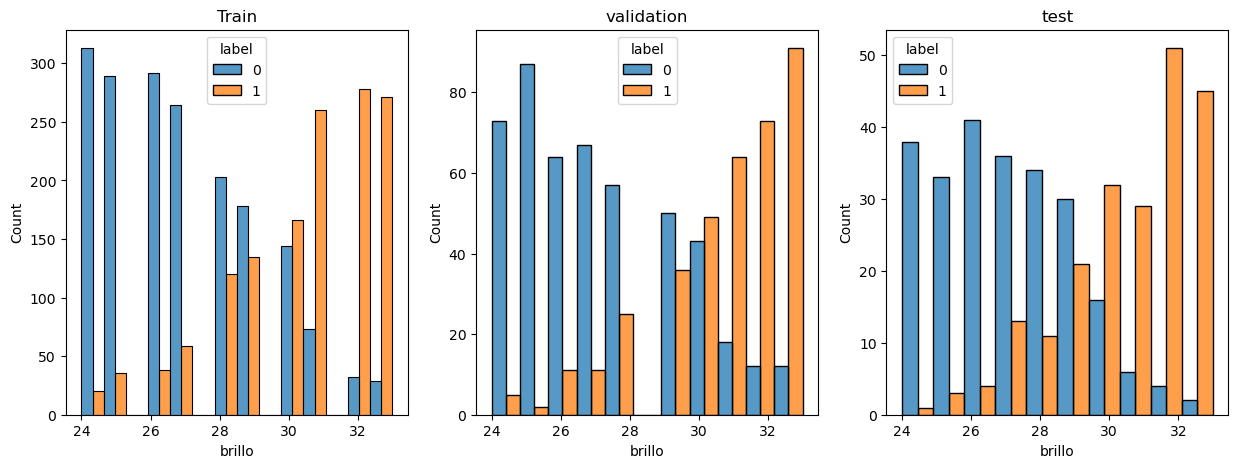

In [208]:
fig,ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(ax=ax[0],data=df_final.loc[df_final["subgrup"]=="train"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[1],data=df_final.loc[df_final["subgrup"]=="val"],x="brillo",hue="label", multiple="dodge")
sns.histplot(ax=ax[2],data=df_final.loc[df_final["subgrup"]=="test"],x="brillo",hue="label", multiple="dodge")
ax[0].set_title('Train')
ax[1].set_title('validation')
ax[2].set_title('test')
fig.show()

In [209]:
def abrir_fits(ruta):
    hdu_list = fits.open(ruta,memmap=False)
    image_data = hdu_list[0].data
    hdu_list.close()
    return image_data

In [210]:
def data_augmentation(path_plots,nomb,img,rng,tipo,numero):
    '''
    Función que genera una imagen fits con rotación al azar entre 0 y 360
    El rng permite que no se repitan las rotaciones
    hay un choice para seleccionar flip en el eje x, y o ambos
    '''

    angulo_de_rotacion = rng.choice(360, size=1, replace=False)[0]
    img_rotate = ndimage.rotate(img,angulo_de_rotacion, reshape=False,mode='reflect')
    flip_x = np.fliplr(img_rotate)
    flip_y = np.flipud(img_rotate)
    flip_xy = np.flipud(np.fliplr(img_rotate))
    mylist = [flip_x,flip_y,flip_xy]
    random_image = random.choice(mylist)
    plt.imshow(random_image, cmap=plt.cm.brg)
    hdu = fits.PrimaryHDU(random_image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(f'{path_plots}{tipo}/{numero}_{nomb}.fits',overwrite=True)
    return

In [211]:
train = df_final.loc[df_final["subgrup"]=="train"].reset_index(drop=True)
val = df_final.loc[df_final["subgrup"]=="val"].reset_index(drop=True)
test = df_final.loc[df_final["subgrup"]=="test"].reset_index(drop=True)

In [212]:
train.to_csv("labels/fits_inclinated/train.csv",index=False)
val.to_csv("labels/fits_inclinated/val.csv",index=False)
test.to_csv("labels/fits_inclinated/test.csv",index=False)

In [230]:
train["image"] = train.parallel_apply(lambda row : abrir_fits(f"{path_data}/fits_inclinated/"+ row["rot"]+"/"+ row["AU"]+".fits"), axis=1)


In [231]:
numero_training = train.groupby(["brillo","label"]).count()["AU"].max()

In [234]:
%mkdir $path_data/fits_inclinated/data_augmentation/

In [235]:
%mkdir $path_data/fits_inclinated/data_augmentation/1

In [236]:
%mkdir $path_data/fits_inclinated/data_augmentation/0

In [237]:
training_df = train.loc[train["label"]==1].reset_index(drop=True)
grouped = training_df.groupby(training_df["brillo"])
for tipos in training_df["brillo"].unique() :
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_inclinated/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_inclinated/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_inclinated/data_augmentation/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")

In [238]:
training_df = train.loc[train["label"]==0].reset_index(drop=True)
grouped = training_df.groupby(training_df["brillo"])
for tipos in training_df["brillo"].unique() :
    
    training = grouped.get_group(tipos)
    if numero_training == len(training):
        continue
    if numero_training/len(training) < 2:
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_inclinated/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
    else : 
        numero_entero = int(numero_training/len(training))
        if numero_training-len(training)*numero_entero != 0 :
            training.head(numero_training-len(training)*numero_entero).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_inclinated/data_augmentation/",row["AU"],row["image"],rng,row["label"],"f"),axis=1,result_type="expand")
        rng = default_rng(42)
        for i in range(numero_entero-1):
            training.head(numero_training - len(training)).parallel_apply(lambda row : data_augmentation(f"{path_data}/fits_inclinated/data_augmentation/",row["AU"],row["image"],rng,row["label"],i),axis=1,result_type="expand")

In [239]:
train.loc[train["label"]==0].parallel_apply(lambda row : shutil.copy(f"{path_data}/fits_inclinated/"+ row["rot"]+"/"+ row["AU"]+".fits",f"{path_data}/fits_inclinated/data_augmentation/0/"),axis=1,result_type="expand")

0       /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
1       /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
4       /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
5       /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
6       /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
                              ...                        
3153    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3155    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3156    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3157    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3168    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
Length: 1817, dtype: object

In [241]:
train.loc[train["label"]==1].parallel_apply(lambda row : shutil.copy(f"{path_data}/fits_inclinated/" + row["rot"]+"/"+ row["AU"]+".fits",f"{path_data}/fits_inclinated/data_augmentation/1/"),axis=1,result_type="expand")

2       /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3       /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
7       /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
59      /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
69      /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
                              ...                        
3195    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3196    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3197    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3198    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
3199    /home/nicolas/nico/Data/SAD_CNN/fits_inclinate...
Length: 1383, dtype: object

In [242]:
%ls $path_data/fits_inclinated/data_augmentation/0 | wc

   3130    3130  114260


In [243]:
%ls $path_data/fits_inclinated/data_augmentation/1 | wc

   3130    3130  115235
